# Download the Data

In [21]:
!pip3 install tqdm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

def get_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        class_name = image_name.split('_')[:-1]
        class_name = '_'.join(class_name)
        image_name = image_name + '.jpg'
        annotations[image_name] = class_name
    
    return annotations, i + 1

Matplotlib is building the font cache; this may take a moment.


In [3]:
if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

In [4]:
train_annotations, _ = get_annotations('data/annotations/trainval.txt')
test_annotations, _ = get_annotations('data/annotations/test.txt')

In [22]:
len(test_annotations.keys()), len(train_annotations.keys())

(1412, 5937)

In [7]:
all_annotations = {}

for key, value in train_annotations.items():
    all_annotations[key] = value
for key, value in test_annotations.items():
    all_annotations[key] = value

In [8]:
train_annotations = {}
test_annotations = {}

for key, value in all_annotations.items():
    if random.randint(0, 99) < 20:
        test_annotations[key] = value
    else:
        train_annotations[key] = value

In [9]:
train_count = len(list(train_annotations.keys()))
test_count = len(list(test_annotations.keys()))

print(train_count)
print(test_count)

5937
1412


# Visualize Data

In [10]:
classes = list(all_annotations.values())

classes = list(set(classes))

print(classes)
print('\nNum of classes:', len(classes))

['yorkshire_terrier', 'Abyssinian', 'beagle', 'saint_bernard', 'leonberger', 'Bombay', 'chihuahua', 'British_Shorthair', 'Russian_Blue', 'english_cocker_spaniel', 'american_pit_bull_terrier', 'staffordshire_bull_terrier', 'basset_hound', 'samoyed', 'english_setter', 'Birman', 'Egyptian_Mau', 'japanese_chin', 'Bengal', 'german_shorthaired', 'havanese', 'shiba_inu', 'keeshond', 'miniature_pinscher', 'wheaten_terrier', 'Ragdoll', 'boxer', 'Siamese', 'Persian', 'scottish_terrier', 'pug', 'american_bulldog', 'Sphynx', 'great_pyrenees', 'Maine_Coon', 'pomeranian', 'newfoundland']

Num of classes: 37


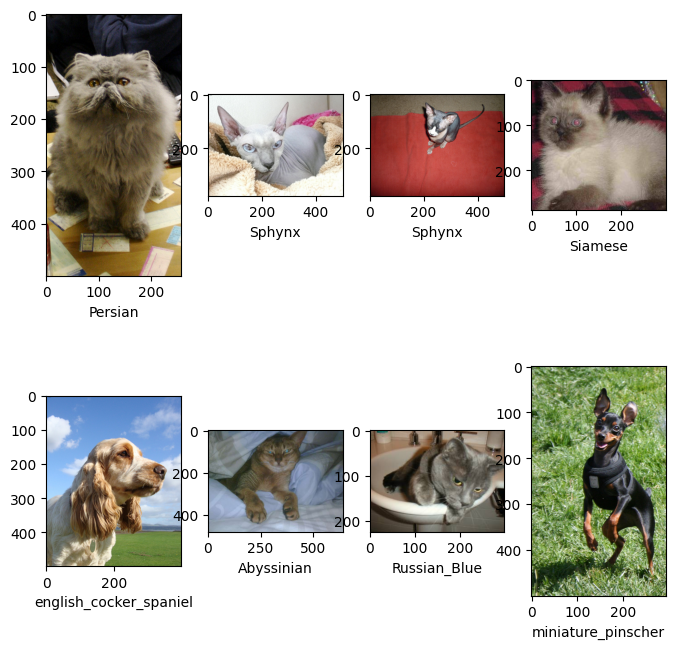

In [11]:
plt.figure(figsize=(8, 8))

train_images = list(train_annotations.keys())

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    image = train_images[random.randint(0, train_count - 1)]
    plt.imshow(plt.imread(os.path.join('data/images/', image)))
    plt.xlabel(train_annotations[image])
plt.show()

# SageMaker Setup

In [85]:
role = sagemaker.get_execution_role()
bucket_name = 'petsdatabucket1'
training_image = get_image_uri(boto3.Session().region_name, 'image-classification',
                              repo_version = 'latest')
print(training_image)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


749696950732.dkr.ecr.eu-west-3.amazonaws.com/image-classification:1


In [14]:
folders = ['train', 'train_lst', 'validation', 'validation_lst']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [15]:
def prepare_data(annotations, key='train'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            shutil.copy(os.path.join('data/images/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()

In [16]:
prepare_data(train_annotations, 'train')

100%|██████████| 5937/5937 [00:05<00:00, 1147.54it/s]


In [17]:
prepare_data(test_annotations, 'validation')

100%|██████████| 1412/1412 [00:02<00:00, 497.39it/s]


# Uploading Data to S3

In [84]:
sess = sagemaker.Session()

#our folder with train data, our s3 bucket, name of folder to be created in the s3 bucket
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print("Training images uploaded")
s3_train_lst_path = sess.upload_data(path='train_lst', bucket=bucket_name, 
                                     key_prefix='train_lst')
print("Training list uploaded")
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name, 
                                      key_prefix='validation')
print("Validation images uploaded")
s3_validation_lst_path = sess.upload_data(path='validation_lst', bucket=bucket_name, 
                                          key_prefix='validation_lst')
print("Validation list uploaded")

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Training images uploaded
Training list uploaded
Validation images uploaded
Validation list uploaded


In [86]:
#data needs to be in s3 so it can be called
s3_validation_lst_path

's3://petsdatabucket1/validation_lst'

# SageMaker Estimator

In [102]:
#High level API used to train a variety of different models
model = sagemaker.estimator.Estimator(
    training_image, role=role, instance_count=1,instance_type='ml.p3.2xlarge',
    volume_size=100, max_run=36000, input_mode='File', 
    output_path='s3://petsdatabucket1/output', sagemaker_session=sess
)

# Hyperparameters

In [103]:
model.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1, #makes my training process faster
    image_shape='3,224,224',
    num_classes=37,
    mini_batch_size=16, # Adjusted mini_batch_size to 16 to match the GPU memory of ml.t3.medium
    resize=224, #resize all images to 224 (used when data is prepared before training)
    epochs=10,
    learning_rate=0.001,#SGD default
    num_training_samples = train_count,
    augmentaion_type='crop_color_transform' #augmentation applied in a random fashion (some cropped and hue and sat may be changed for some, sheer may be applied etc...)    
)

# Data Channels

In [104]:
#create a dictionary of the training data, validation data etc... 
#data is on a directory like s3
train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution='FullyReplicated',
                          content_type='application/x-image', s3_data_type='S3Prefix')

validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution='FullyReplicated',
                          content_type='application/x-image', s3_data_type='S3Prefix')


train_lst_data = sagemaker.inputs.TrainingInput(s3_train_lst_path, distribution='FullyReplicated',
                          content_type='application/x-image', s3_data_type='S3Prefix')

validation_lst_data = sagemaker.inputs.TrainingInput(s3_validation_lst_path, distribution='FullyReplicated',
                          content_type='application/x-image', s3_data_type='S3Prefix')

In [105]:
data_channels = {
    'train' : train_data,
    'train_lst' : train_lst_data,
    'validation' : validation_data,
    'validation_lst' : validation_lst_data
}
#creating references for places in S3

# Model Training

In [106]:
model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: image-classification-2023-07-11-05-20-38-725


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The requested resource training-job/ml.p3.2xlarge is not available in this region

In [80]:
model.hyperparameters()

{'num_layers': 18,
 'use_pretrained_model': 1,
 'image_shape': '3,224,224',
 'num_classes': 37,
 'mini_batch_size': 32,
 'resize': 224,
 'epochs': 10,
 'learning_rate': 0.001,
 'num_training_samples': 5937,
 'augmentaion_type': 'crop_color_transorm'}

# Deploy Model

In [107]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print("Model Deployed")

#In the bucket, should be a new folder containning the model

ValueError: Estimator is not associated with a training job

# Predictions

In [ ]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

In [ ]:
deployed_model.content_type = 'image/jpeg'

In [ ]:
i = 0
image_path = os.path.join(image_dir, images[i])
with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)
results.json.loads(results)

In [ ]:
classes[np.argmax(results)]

In [ ]:
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [108]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


NameError: name 'deployed_model' is not defined